In [133]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers 
import os
import shutil
import pathlib

In [134]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [135]:
DATASET_PATH = pathlib.Path('C:\\Users\\...\\Leaves')

def load_image(DATASET_PATH):
    image = cv2.imread(DATASET_PATH, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

def load_image_and_display_channels(DATASET_PATH):
    for image in DATASET_PATH.glob('*.jpg'):
        image = cv2.imread(DATASET_PATH, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]
        nir_channel = image[:, :, 3] 
        
        red_channel = red_channel.astype(np.float32)
        green_channel = green_channel.astype(np.float32)
        blue_channel = blue_channel.astype(np.float32)
        nir_channel = nir_channel.astype(np.float32)

        red_color = np.zeros_like(image)
        red_color[:, :, 0] = red_channel

        green_color = np.zeros_like(image)
        green_color[:, :, 1] = green_channel

        blue_color = np.zeros_like(image)
        blue_color[:, :, 2] = blue_channel

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(red_color)
        axs[0].set_title('Red Channel')
        axs[0].axis('off')

        axs[1].imshow(green_color)
        axs[1].set_title('Green Channel')
        axs[1].axis('off')

        axs[2].imshow(blue_color)
        axs[2].set_title('Blue Channel')
        axs[2].axis('off')

        plt.show()
    
        bottom = (nir + red)
        bottom[bottom == 0] = 0.01
        ndvi = (nir - red) / bottom
        print("NDVI Shape:", ndvi.shape)
        print("NDVI Value at (0,0):", ndvi[0, 0])

        ndvi = cv2.normalize(ndvi, None, 0, 255, cv2.NORM_MINMAX)
        ndvi = ndvi.astype(np.uint8)
        return ndvi

In [136]:
def classify_ndvi(ndvi):
    classification = np.zeros_like(ndvi, dtype = int)
    classification[(ndvi >= 0) & (ndvi < 0.33)] = 1
    classification[(ndvi >= 0.33) & (ndvi < 0.66)] = 2
    classification[(ndvi >= 0.66) & (ndvi <= 1)] = 3
    return classification

In [137]:
def classify_and_move_images(healthy_folder, moderately_healthy_folder, unhealthy_folder):
   healthy_folder = pathlib.Path('C:\\Users\\baska\\...\\healthy_folder')
   moderately_healthy_folder = pathlib.Path('C:\\Users\\...\\Leaves\\moderately_healthy_folder')
   unhealthy_folder = pathlib.Path('C:\\Users\\...\\Leaves\\unhealthy_folder')
    
   leaves_folder_path = pathlib.Path("plants")
   
   image_paths = [os.path.join(leaves_folder_path, file) for file in os.listdir(leaves_folder_path) if file.endswith(('.jpg'))]

   for image_path in image_paths:
        
        if  ndvi > 0.6: 
            shutil.move(image_path, os.path.join(healthy_folder, os.path.basename(image_path)))
        elif 0.33 <= ndvi <= 0.6:  
            shutil.move(image_path, os.path.join(moderately_healthy_folder, os.path.basename(image_path)))
        else:  
            shutil.move(image_path, os.path.join(unhealthy_folder, os.path.basename(image_path)))

In [138]:
IMAGE_SIZE = 130
IMAGE_SIZE2 = 160
BATCH_SIZE = 4
CHANNELS = 3
EPOCHS = 100

In [139]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "plants",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE2),
    batch_size = BATCH_SIZE,
)

Found 38 files belonging to 3 classes.


In [140]:
len(dataset)

10

In [141]:
class_names = dataset.class_names
class_names

['healthy_folder', 'moderately_healthy_folder', 'unhealthy_folder']

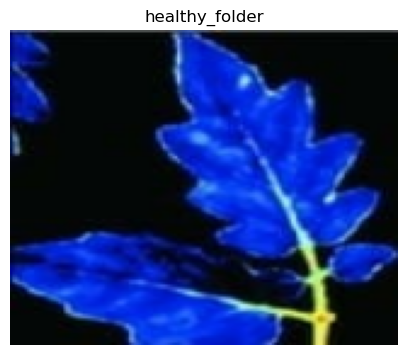

In [144]:
plt.figure(figsize=(5, 5))
for image_batch, labels_batch in dataset.take(1):
    for i in range(1):
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [104]:
len(dataset)

10

In [105]:
train_size = 0.8
len(dataset)*train_size

8.0

In [106]:
train_ds = dataset.take(8)

In [107]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [108]:
val_size = 0.1
len(dataset)*val_size

1.0

In [109]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=4)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [110]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [111]:
len(train_ds)

8

In [112]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [113]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [114]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [115]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [116]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE2, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(4, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [117]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (4, 130, 130, 3)          0         
                                                                 
 conv2d_12 (Conv2D)          (4, 128, 128, 4)          112       
                                                                 
 max_pooling2d_12 (MaxPoolin  (4, 64, 64, 4)           0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (4, 62, 62, 8)            296       
                                                                 
 max_pooling2d_13 (MaxPoolin  (4, 31, 31, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (4, 29, 29, 8)          

In [118]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [119]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
8/8 [==============================] - 1s 52ms/step - loss: 1.1634 - accuracy: 0.2812 - val_loss: 1.0591 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0955 - accuracy: 0.4375 - val_loss: 1.0632 - val_accuracy: 0.5000
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0817 - accuracy: 0.3750 - val_loss: 1.0411 - val_accuracy: 0.5000
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 1.0724 - accuracy: 0.4375 - val_loss: 1.0151 - val_accuracy: 0.5000
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0760 - accuracy: 0.3438 - val_loss: 0.9949 - val_accuracy: 0.5000
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0727 - accuracy: 0.3750 - val_loss: 0.9952 - val_accuracy: 0.5000
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 1.0712 - accuracy: 0.4688 - val_loss: 1.0022 - val_accuracy: 0.5000
Epoch 8/100
8/8 [===

In [120]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 0s 53ms/step - loss: 0.0675 - accuracy: 1.0000


In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

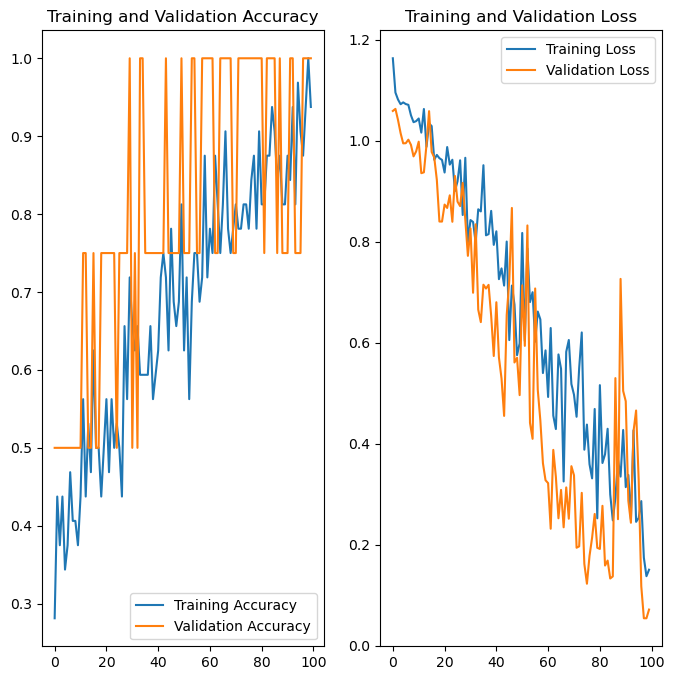

In [126]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: unhealthy_folder
1/1 [==============================] - 0s 20ms/step
predicted label: unhealthy_folder


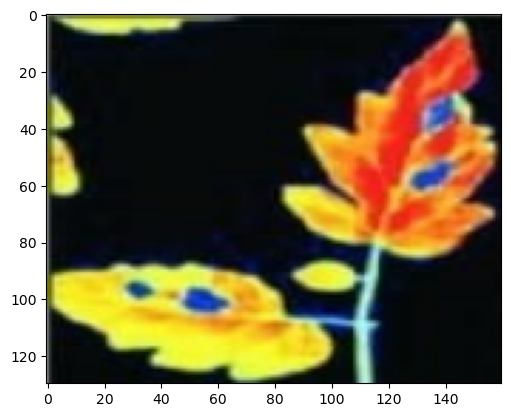

In [127]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [128]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


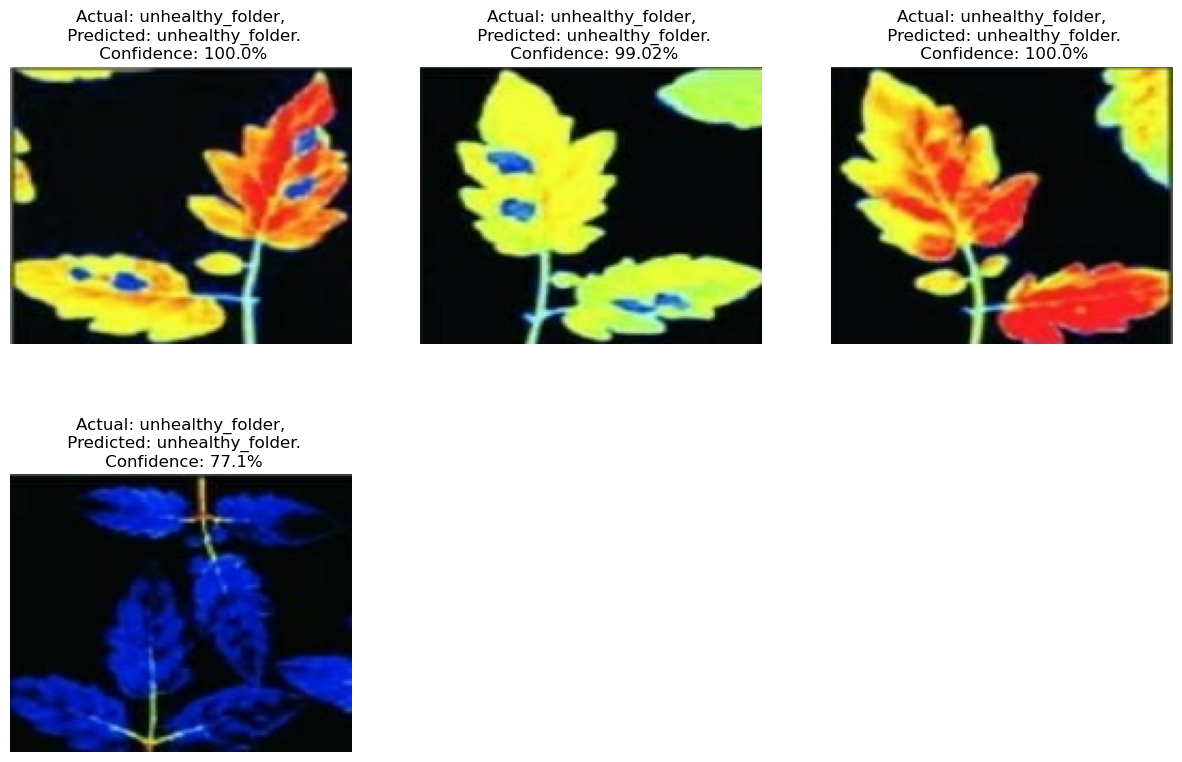

In [129]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")